<a href="https://colab.research.google.com/github/MohHasan1/SEA600--Assignment-1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [119]:
# Install required libraries
!pip install imbalanced-learn ucimlrepo --quiet

In [120]:
# Import necessary libraries
import time
import tracemalloc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Import imbalanced-learn methods
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from ucimlrepo import fetch_ucirepo

# **Importing the DataSet**

In [121]:
# fetch dataset
heart_failure_clinical_records = fetch_ucirepo(id=519)


# data (as pandas dataframes)
X = heart_failure_clinical_records.data.features
y = heart_failure_clinical_records.data.targets

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
print(X.shape)
print(y.shape)

# **Data Preprocessing - 1**

In [15]:
# 1. Check for missing data

print("Missing values in each feature:")
print(X.isna().sum())

Missing values in each feature:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64


There are no missing values

In [16]:
# 2. Basic descriptive statistics
print("\nDescriptive statistics:")
display(X.describe())


Descriptive statistics:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000


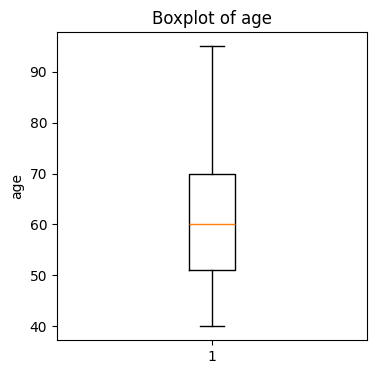

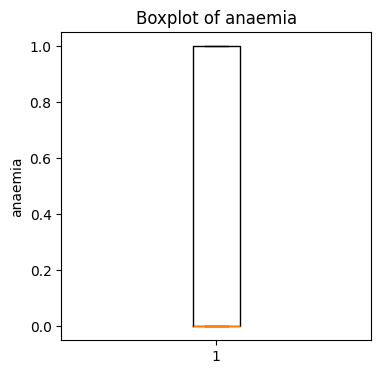

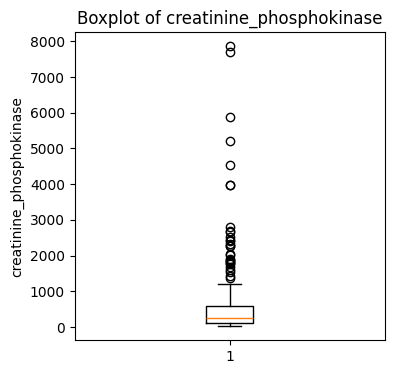

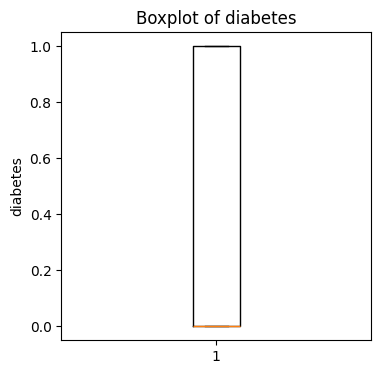

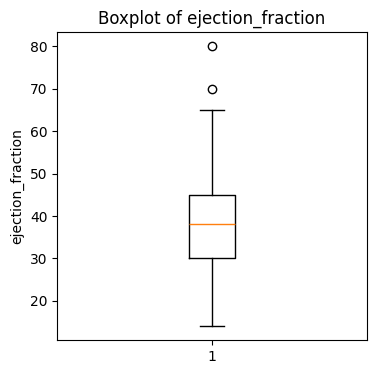

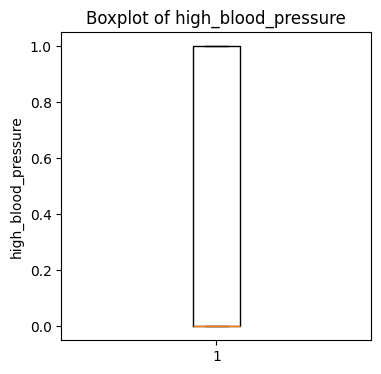

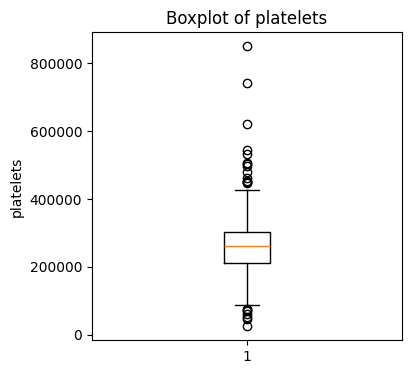

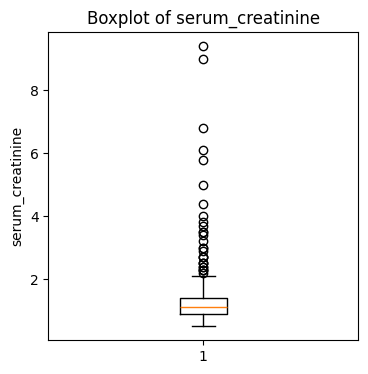

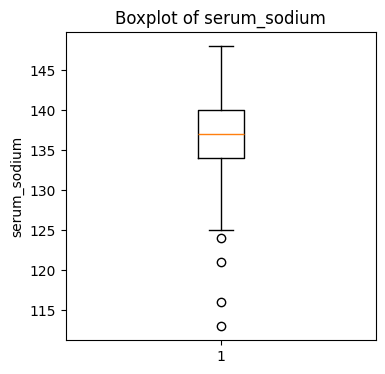

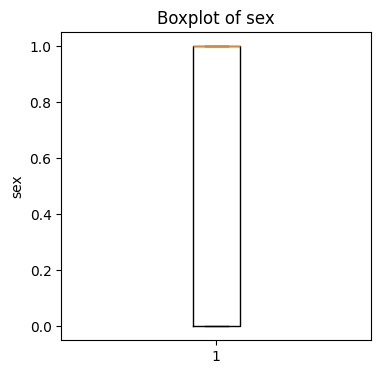

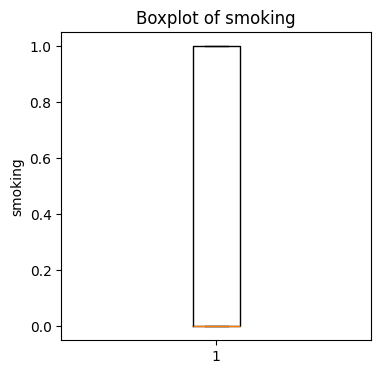

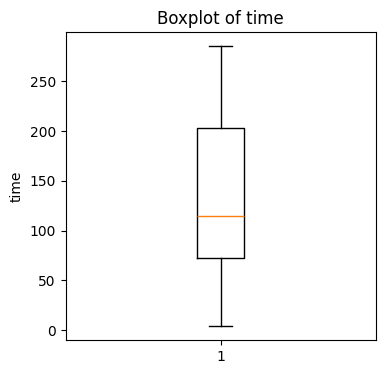

In [17]:
# 3. Boxplots to visualize potential outliers for each numeric column
numeric_cols = X.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure(figsize=(4, 4))
    plt.boxplot(X[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

In [18]:
# 4. Identifying outliers using the IQR (interquartile range) method
outliers_dict = {}

for col in numeric_cols:
    col_data = X[col].dropna()
    Q1 = np.percentile(col_data, 25)
    Q3 = np.percentile(col_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
    outliers_dict[col] = outliers

# Print outlier info
for col, outliers in outliers_dict.items():
    print(f"\nOutliers in '{col}':")
    if len(outliers) > 0:
        print(outliers)
    else:
        print("No outliers detected by IQR rule")


Outliers in 'age':
No outliers detected by IQR rule

Outliers in 'anaemia':
No outliers detected by IQR rule

Outliers in 'creatinine_phosphokinase':
1      7861
38     2656
46     1380
52     3964
60     7702
72     5882
103    5209
107    1876
130    1808
134    4540
139    1548
147    1610
149    2261
153    1846
163    2334
164    2442
171    3966
176    1419
187    1896
200    1767
208    2281
227    2794
246    2017
250    2522
280    2695
283    1688
295    1820
296    2060
297    2413
Name: creatinine_phosphokinase, dtype: int64

Outliers in 'diabetes':
No outliers detected by IQR rule

Outliers in 'ejection_fraction':
64     80
217    70
Name: ejection_fraction, dtype: int64

Outliers in 'high_blood_pressure':
No outliers detected by IQR rule

Outliers in 'platelets':
7      454000.0
15      47000.0
47     451000.0
55     461000.0
69     497000.0
105    621000.0
109    850000.0
117    507000.0
162    448000.0
163     75000.0
167     70000.0
200     73000.0
212    481000.0
224

Using the 1.5×IQR rule, I found that the features age, anaemia, diabetes, high_blood_pressure, sex, smoking, and time had no outliers. This means all their values fell within the typical lower and upper boundaries.

On the other hand, creatinine_phosphokinase had 29 outliers, ejection_fraction had 2, platelets had 21, serum_creatinine had 30, and serum_sodium had 4. These values lie outside the usual range, so it might be useful to investigate or remove them before further analysis.

In [122]:
# 4. Identify outliers using the IQR (Interquartile Range) rule
outlier_indices = set()

for col in numeric_cols:
    col_data = X[col].dropna()
    Q1 = np.percentile(col_data, 25)
    Q3 = np.percentile(col_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outlier rows
    is_outlier = (col_data < lower_bound) | (col_data > upper_bound)
    # Add these row indices to the outlier set
    outlier_indices.update(col_data[is_outlier].index)

print(f"\nTotal number of outliers across all numeric columns: {len(outlier_indices)}")

# 5. Remove those outliers from X and y
X_no_outliers = X.drop(index=outlier_indices)
y_no_outliers = y.drop(index=outlier_indices)

print("\nShapes before and after outlier removal:")
print(f"Original X shape: {X.shape}, y shape: {y.shape}")
print(f"X_no_outliers shape: {X_no_outliers.shape}, y_no_outliers shape: {y_no_outliers.shape}")


Total number of outliers across all numeric columns: 75

Shapes before and after outlier removal:
Original X shape: (299, 12), y shape: (299, 1)
X_no_outliers shape: (224, 12), y_no_outliers shape: (224, 1)


# **Data Exploration - 1**

In [123]:
# 1. Check for data Imbalance
count_0_1 = y_no_outliers['death_event'].value_counts().loc[[0, 1]]
print(count_0_1)

death_event
0    163
1     61
Name: count, dtype: int64


**Data Imbalance** \
The dataset has more “no death” events (majority class) than “death” events (minority class). This imbalance can make it hard for models to correctly predict the minority class.

**Three Sampling Methods**

* **Oversampling the minority class**: Duplicate or generate new samples from the minority class.
* **Undersampling the majority class**: Remove some samples from the majority class.
* **Combination of over- and undersampling**: Use both methods carefully to balance the classes.

*Because our dataset is relatively small, oversampling is a good choice. It increases the number of minority samples without discarding valuable majority data.*

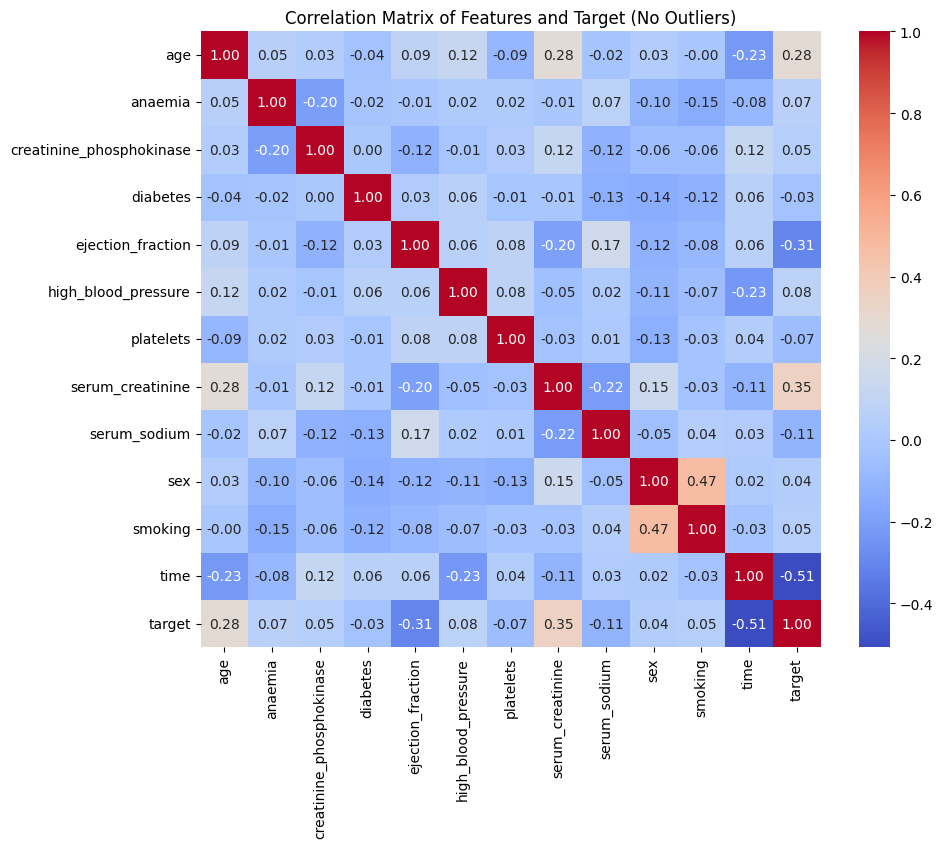

In [124]:
# 1. Combine X_no_outliers and y_no_outliers into a single DataFrame
df_ib = X_no_outliers.copy()
df_ib['target'] = y_no_outliers

# 2. Compute the correlation matrix
corr_matrix = df_ib.corr()

# 3. Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Target (No Outliers)')
plt.show()


I can look at correlations in the entire dataset to get a broad overview, but outliers might skew the results. If I’m going to remove outliers anyway, it’s better to check the correlation matrix after cleaning so that I see the true relationships in the data I’ll actually use.

# **Data preprocessing - 2**

In [125]:
# 1. Data Spliting (after removing outliers)


# Split into train_val (80%) and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Split train_val (80%) to train (60%) and val (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Display shapes to verify the split
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Check absolute counts
print("\nClass Counts in Each Set:")
print("Train:\n", y_train.value_counts())
print("Validation:\n", y_val.value_counts())
print("Test:\n", y_test.value_counts())


Train set shape: (134, 12)
Validation set shape: (45, 12)
Test set shape: (45, 12)

Class Counts in Each Set:
Train:
 death_event
0              99
1              35
Name: count, dtype: int64
Validation:
 death_event
0              30
1              15
Name: count, dtype: int64
Test:
 death_event
0              34
1              11
Name: count, dtype: int64


After the outlier is removed, and dealing with missing data (there was none), I split the dataset into 3 parts: Train, validation and test.

In [126]:
# 1. Over sample the Training DataSet

# The training data set is only sampled (Outliers where removed)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape, y_train.shape)
print("After SMOTE:", X_train_resampled.shape, y_train_resampled.shape)

Before SMOTE: (134, 12) (134, 1)
After SMOTE: (198, 12) (198, 1)


In [127]:
# 2. Fit the scaler on the training data after SMOT
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# 2. Transform the validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (198, 12)
X_val_scaled shape: (45, 12)
X_test_scaled shape: (45, 12)


In [98]:

# Check mean and standard deviation of the scaled training set
print("Mean of X_train_scaled (should be approx. 0):\n", np.mean(X_train_scaled, axis=0))
print("\nStandard deviation of X_train_scaled (should be approx. 1):\n", np.std(X_train_scaled, axis=0))

# Check mean and standard deviation of the validation set
print("\nMean of X_val_scaled:\n", np.mean(X_val_scaled, axis=0))
print("\nStandard deviation of X_val_scaled:\n", np.std(X_val_scaled, axis=0))

# Check mean and standard deviation of the test set
print("\nMean of X_test_scaled:\n", np.mean(X_test_scaled, axis=0))
print("\nStandard deviation of X_test_scaled:\n", np.std(X_test_scaled, axis=0))


Mean of X_train_scaled (should be approx. 0):
 [ 1.46503657e-16 -9.15647855e-17  7.32518284e-17 -1.28190700e-16
 -9.61430248e-17  3.20476749e-17  4.57823928e-18  2.93007314e-16
 -2.30857716e-15 -3.66259142e-17 -5.49388713e-17  7.32518284e-17]

Standard deviation of X_train_scaled (should be approx. 1):
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Mean of X_val_scaled:
 [-2.45696258e-01  2.34831802e-01  5.00062393e-02 -2.39280845e-04
  1.45891563e-01 -7.41526659e-02  4.49075382e-01 -1.69877771e-01
  4.01765866e-02  4.25791737e-01  2.37009163e-01  6.06166162e-01]

Standard deviation of X_val_scaled:
 [0.95877708 1.01163245 1.08242997 0.99992783 1.11138362 0.98061923
 1.01484864 1.10155416 1.09658885 0.88518623 1.10170714 1.01500305]

Mean of X_test_scaled:
 [-0.29445141 -0.08060003 -0.11904416  0.13902217  0.25785283  0.06241965
  0.09385437 -0.07483985  0.17612294  0.20338033  0.03242728  0.60676935]

Standard deviation of X_test_scaled:
 [0.95063842 0.98313003 0.99169161 1.03174682 1.281909

All features now have a mean near 0 and a standard deviation near 1, there might a be tiny differences from 0 and 1 come from floating-point rounding.

# **Data Exploration - 2**

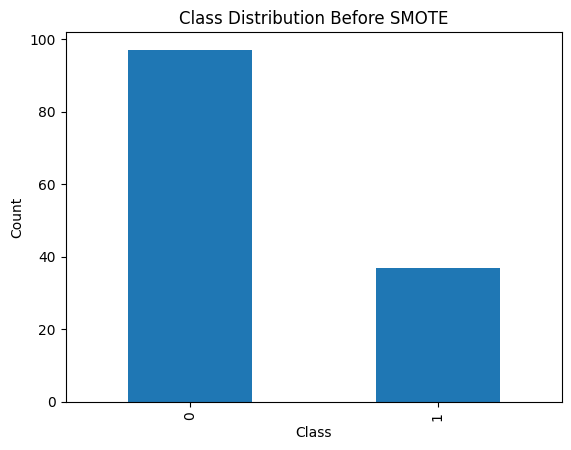

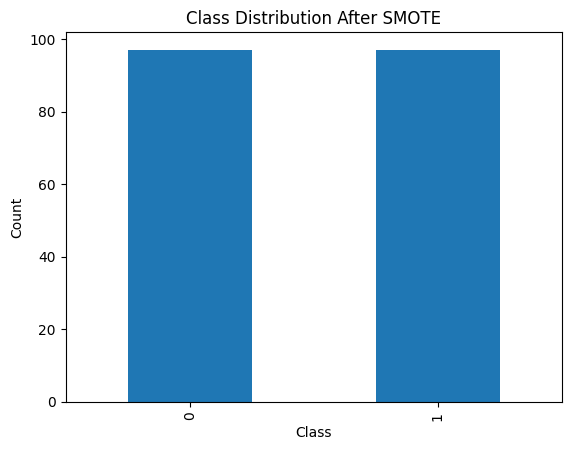

In [99]:
# 1.

# Convert y_train and y_train_resampled to NumPy arrays, then flatten them
y_train_flat = y_train.to_numpy().ravel()
y_train_resampled_flat = y_train_resampled.to_numpy().ravel()

# Visualize class distribution BEFORE SMOTE
plt.figure()
pd.Series(y_train_flat).value_counts().plot(kind='bar')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Visualize class distribution AFTER SMOTE
plt.figure()
pd.Series(y_train_resampled_flat).value_counts().plot(kind='bar')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


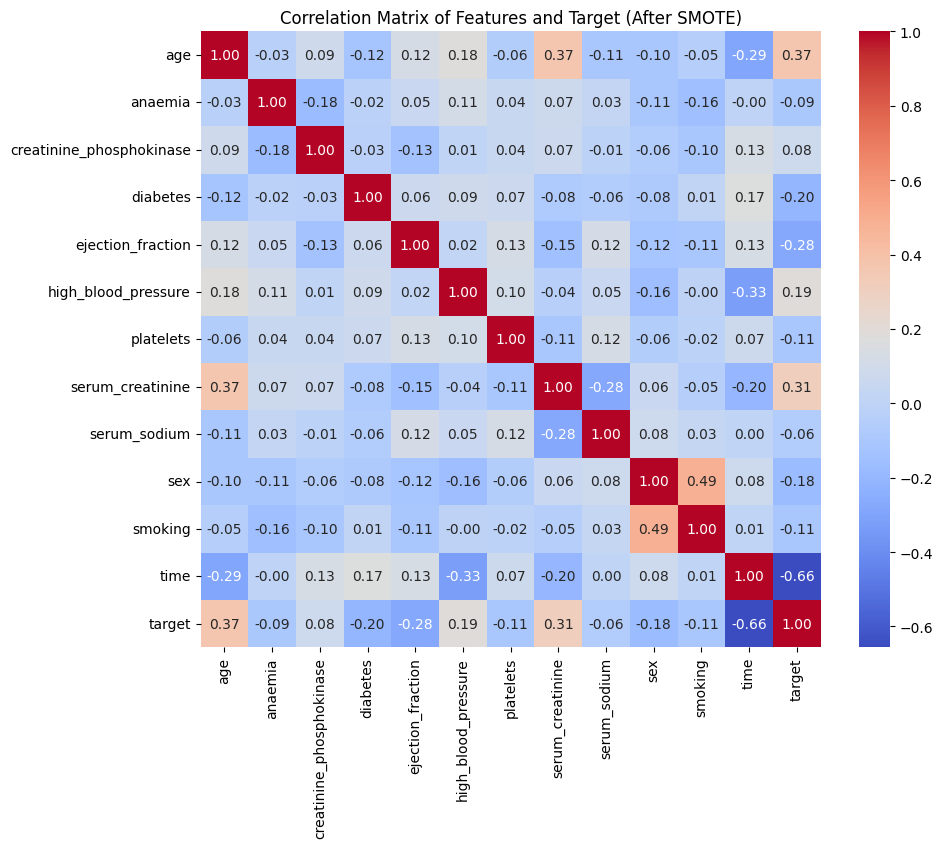

In [100]:
# correlation matrix for tarining data set after over smapling

# 1. Combine X_train_resampled and y_train_resampled into one DataFrame
df_resampled = X_train_resampled.copy()
df_resampled['target'] = y_train_resampled.to_numpy().ravel()  # Ensure y is 1D

# 2. Compute the correlation matrix
corr_matrix = df_resampled.corr()

# 3. Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Target (After SMOTE)')
plt.show()


# My Data Preprocessing Steps

## 1. Clean the Data
- Remove any outliers.
- Handle missing values (e.g., imputation or dropping rows).

## 2. Split the Data
- Split the cleaned dataset into train and test sets.
  - Example ratio: 80% training, 20% test.

## 3. Handle Class Imbalance (Training Set Only)
- Use an oversampling method like **RandomOverSampler** or **SMOTE** on the training set.

## 4. Scale the Features
- Fit a scaler (such as **StandardScaler**) on the oversampled training set.
- Transform both the training and test sets using the same scaler.

## 5. Train and Evaluate
- Train the model on the oversampled, scaled training data.
- Evaluate on the untouched, scaled test set to get a fair performance measure.


# **Milestone-1 (Baseline)**

In [128]:
# Convert feature data to NumPy arrays to avoid feature names warning
X_train_scaled_np = X_train_scaled.to_numpy() if hasattr(X_train_scaled, "to_numpy") else X_train_scaled
X_val_scaled_np = X_val_scaled.to_numpy() if hasattr(X_val_scaled, "to_numpy") else X_val_scaled

# Convert y_train to 1D NumPy array
y_train_resampled_np = y_train_resampled.to_numpy().ravel()

I did not sample the validation set because it needs to reflect real-world data. If I oversample it, the model’s performance won’t be realistic. The validation set stays imbalanced so I can properly test how well the model handles actual data. I only oversampled the training set to help the model learn better.

In [129]:
# ----- K-Nearest Neighbors (KNN) Classifier ----- #

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

# Initialize and train KNN model
model_knn = KNeighborsClassifier(n_neighbors=3, weights='distance')  # Adjusted n_neighbors & added distance weighting
model_knn.fit(X_train_scaled_np, y_train_resampled_np)

# Stop tracking time
training_time_knn = time.time() - start_time
current_knn, peak_knn = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Evaluate KNN on the validation set
y_pred_knn = model_knn.predict(X_val_scaled_np)

# Compute performance metrics (handle zero division warning)
acc_knn = accuracy_score(y_val, y_pred_knn)
precision_knn = precision_score(y_val, y_pred_knn, zero_division=1)
recall_knn = recall_score(y_val, y_pred_knn, zero_division=1)
roc_auc_knn = roc_auc_score(y_val, model_knn.predict_proba(X_val_scaled_np)[:, 1])

# Print results
print("_______________________________________________________________________")
print("\n----- K-Nearest Neighbors (KNN) on Validation Set -----")
print(f"Accuracy       : {acc_knn:.4f}")
print(f"Precision      : {precision_knn:.4f}")
print(f"Recall         : {recall_knn:.4f}")
print(f"ROC AUC        : {roc_auc_knn:.4f}")
print(f"Training time  : {training_time_knn:.4f} seconds")
print(f"Peak memory    : {peak_knn / 10**6:.4f} MB")

print("_______________________________________________________________________\n")
print("Classification Report:")
print("_______________________________________________________________________\n")
print(classification_report(y_val, y_pred_knn, zero_division=1))
print("_______________________________________________________________________\n")


_______________________________________________________________________

----- K-Nearest Neighbors (KNN) on Validation Set -----
Accuracy       : 0.7556
Precision      : 0.6111
Recall         : 0.7333
ROC AUC        : 0.8356
Training time  : 0.0068 seconds
Peak memory    : 0.0491 MB
_______________________________________________________________________

Classification Report:
_______________________________________________________________________

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        30
           1       0.61      0.73      0.67        15

    accuracy                           0.76        45
   macro avg       0.73      0.75      0.74        45
weighted avg       0.77      0.76      0.76        45

_______________________________________________________________________



In [130]:
# ----- Decision Tree Classifier ----- #

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

# Initialize and train Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_scaled_np, y_train_resampled_np)

# Stop tracking time
training_time_dt = time.time() - start_time
current_dt, peak_dt = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Evaluate Decision Tree on the validation set
y_pred_dt = model_dt.predict(X_val_scaled_np)

# Compute performance metrics (handle zero division warning)
acc_dt = accuracy_score(y_val, y_pred_dt)
precision_dt = precision_score(y_val, y_pred_dt, zero_division=1)
recall_dt = recall_score(y_val, y_pred_dt, zero_division=1)
roc_auc_dt = roc_auc_score(y_val, model_dt.predict_proba(X_val_scaled_np)[:, 1])

# Print results
print("_______________________________________________________________________")
print("\n----- Decision Tree on Validation Set -----")
print(f"Accuracy       : {acc_dt:.4f}")
print(f"Precision      : {precision_dt:.4f}")
print(f"Recall         : {recall_dt:.4f}")
print(f"ROC AUC        : {roc_auc_dt:.4f}")
print(f"Training time  : {training_time_dt:.4f} seconds")
print(f"Peak memory    : {peak_dt / 10**6:.4f} MB")

print("_______________________________________________________________________\n")
print("Classification Report:")
print("_______________________________________________________________________\n")
print(classification_report(y_val, y_pred_dt, zero_division=1))
print("_______________________________________________________________________\n")


_______________________________________________________________________

----- Decision Tree on Validation Set -----
Accuracy       : 0.7111
Precision      : 0.5625
Recall         : 0.6000
ROC AUC        : 0.6833
Training time  : 0.0096 seconds
Peak memory    : 0.0353 MB
_______________________________________________________________________

Classification Report:
_______________________________________________________________________

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        30
           1       0.56      0.60      0.58        15

    accuracy                           0.71        45
   macro avg       0.68      0.68      0.68        45
weighted avg       0.72      0.71      0.71        45

_______________________________________________________________________



# **Milestone-2**

In [131]:
# ----- LDA ----- #

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

# Initialize and train LDA model
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train_scaled_np, y_train_resampled_np)

# Stop tracking time
training_time_lda = time.time() - start_time
current_lda, peak_lda = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Evaluate LDA on the validation set
y_pred_lda = model_lda.predict(X_val_scaled_np)

# Compute performance metrics (handle zero division warning)
acc_lda = accuracy_score(y_val, y_pred_lda)
precision_lda = precision_score(y_val, y_pred_lda, zero_division=1)
recall_lda = recall_score(y_val, y_pred_lda, zero_division=1)
roc_auc_lda = roc_auc_score(y_val, model_lda.predict_proba(X_val_scaled_np)[:, 1])

print("_______________________________________________________________________")
print("\n----- Linear Discriminant Analysis (LDA) on Validation Set -----")
print(f"Accuracy       : {acc_lda:.4f}")
print(f"Precision      : {precision_lda:.4f}")
print(f"Recall         : {recall_lda:.4f}")
print(f"ROC AUC        : {roc_auc_lda:.4f}")
print(f"Training time  : {training_time_lda:.4f} seconds")
print(f"Peak memory    : {peak_lda / 10**6:.4f} MB")

print("_______________________________________________________________________\n")
print("Classification Report:")
print("_______________________________________________________________________\n")
print(classification_report(y_val, y_pred_lda))
print("_______________________________________________________________________\n")


_______________________________________________________________________

----- Linear Discriminant Analysis (LDA) on Validation Set -----
Accuracy       : 0.7778
Precision      : 0.6471
Recall         : 0.7333
ROC AUC        : 0.8133
Training time  : 0.0113 seconds
Peak memory    : 0.1014 MB
_______________________________________________________________________

Classification Report:
_______________________________________________________________________

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.65      0.73      0.69        15

    accuracy                           0.78        45
   macro avg       0.75      0.77      0.76        45
weighted avg       0.79      0.78      0.78        45

_______________________________________________________________________



In [132]:
# ----- QDA ----- #

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

# Initialize and train QDA model
model_qda = QuadraticDiscriminantAnalysis()
model_qda.fit(X_train_scaled_np, y_train_resampled_np)

# Stop tracking time
training_time_qda = time.time() - start_time
current_qda, peak_qda = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Evaluate QDA on the validation set
y_pred_qda = model_qda.predict(X_val_scaled_np)

# Compute performance metrics (handle zero division warning)
acc_qda = accuracy_score(y_val, y_pred_qda)
precision_qda = precision_score(y_val, y_pred_qda)
recall_qda = recall_score(y_val, y_pred_qda, zero_division=1)
roc_auc_qda = roc_auc_score(y_val, model_qda.predict_proba(X_val_scaled_np)[:, 1])  # Fixed input here

print("_______________________________________________________________________")
print("\n----- Quadratic Discriminant Analysis (QDA) on Validation Set -----")
print(f"Accuracy       : {acc_qda:.4f}")
print(f"Precision      : {precision_qda:.4f}")
print(f"Recall         : {recall_qda:.4f}")
print(f"ROC AUC        : {roc_auc_qda:.4f}")
print(f"Training time  : {training_time_qda:.4f} seconds")
print(f"Peak memory    : {peak_qda / 10**6:.4f} MB")

print("_______________________________________________________________________\n")
print("Classification Report:")
print("_______________________________________________________________________\n")
print(classification_report(y_val, y_pred_qda))
print("_______________________________________________________________________\n")


_______________________________________________________________________

----- Quadratic Discriminant Analysis (QDA) on Validation Set -----
Accuracy       : 0.7778
Precision      : 1.0000
Recall         : 0.3333
ROC AUC        : 0.7444
Training time  : 0.0072 seconds
Peak memory    : 0.0645 MB
_______________________________________________________________________

Classification Report:
_______________________________________________________________________

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        30
           1       1.00      0.33      0.50        15

    accuracy                           0.78        45
   macro avg       0.88      0.67      0.68        45
weighted avg       0.83      0.78      0.74        45

_______________________________________________________________________



The issue with my QDA model is that it's too conservative in predicting class 1, leading to high precision (1.0) but low recall (0.33). This happens because the validation set is still imbalanced, and QDA may be setting a high probability threshold for class 1. As a result, it predicts very few positives but does so with high confidence.

I can fix this by adjusting the decision threshold for class 1. By default, QDA predicts class 1 when P(class=1) > 0.5, but since it's too conservative, I can lower the threshold to make it predict more positives, improving recall.

In [135]:
# ----- QDA (changed) ----- #

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

# Initialize and train QDA model
model_qda = QuadraticDiscriminantAnalysis()
model_qda.fit(X_train_scaled_np, y_train_resampled_np)

# Stop tracking time
training_time_qda = time.time() - start_time
current_qda, peak_qda = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Evaluate QDA on the validation set
y_proba_qda = model_qda.predict_proba(X_val_scaled_np)[:, 1]  # Get probability for class 1

# --- Adjust Decision Threshold --- #
threshold = 0.3  # Lower threshold from default 0.5 to 0.3 to improve recall
y_pred_qda_adjusted = (y_proba_qda >= threshold).astype(int)

# Compute performance metrics (handle zero division warning)
acc_qda = accuracy_score(y_val, y_pred_qda_adjusted)
precision_qda = precision_score(y_val, y_pred_qda_adjusted, zero_division=1)
recall_qda = recall_score(y_val, y_pred_qda_adjusted, zero_division=1)
roc_auc_qda = roc_auc_score(y_val, y_proba_qda)  # Use probabilities for AUC calculation

# Print results
print("_______________________________________________________________________")
print("\n----- Quadratic Discriminant Analysis (QDA) on Validation Set -----")
print(f"Accuracy       : {acc_qda:.4f}")
print(f"Precision      : {precision_qda:.4f}")
print(f"Recall         : {recall_qda:.4f}")
print(f"ROC AUC        : {roc_auc_qda:.4f}")
print(f"Training time  : {training_time_qda:.4f} seconds")
print(f"Peak memory    : {peak_qda / 10**6:.4f} MB")

print("_______________________________________________________________________\n")
print("Classification Report (After Threshold Adjustment):")
print("_______________________________________________________________________\n")
print(classification_report(y_val, y_pred_qda_adjusted, zero_division=1))
print("_______________________________________________________________________\n")


_______________________________________________________________________

----- Quadratic Discriminant Analysis (QDA) on Validation Set -----
Accuracy       : 0.7778
Precision      : 0.8571
Recall         : 0.4000
ROC AUC        : 0.7444
Training time  : 0.0069 seconds
Peak memory    : 0.0581 MB
_______________________________________________________________________

Classification Report (After Threshold Adjustment):
_______________________________________________________________________

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        30
           1       0.86      0.40      0.55        15

    accuracy                           0.78        45
   macro avg       0.81      0.68      0.70        45
weighted avg       0.79      0.78      0.75        45

_______________________________________________________________________



After adjusting the threshold, my QDA model predicts more class 1s, improving recall from 0.33 to 0.40, but it's still favoring class 0. Precision dropped slightly (1.00 → 0.86), but the model is now more balanced. The validation set is still imbalanced, so recall is limited. Lowering the threshold more (0.2) or using class weights could help, but if QDA still struggles, I might switch to Random Forest for better performance.

# **Milestone-3**

After using Random Forest with balanced class weights, my model improved recall (0.40 → 0.73) while keeping decent precision (0.69). Accuracy is now 80%, and ROC AUC is 0.88, meaning the model separates classes well. The overall F1-score is balanced, so Random Forest performs better than QDA for this dataset.

In [136]:
# ----- Random Forest Classifier (Ensemble classifier) EXTRA ----- #


# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

# Initialize and train Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model_rf.fit(X_train_scaled_np, y_train_resampled_np)

# Stop tracking time
training_time_rf = time.time() - start_time
current_rf, peak_rf = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Evaluate Random Forest on the validation set
y_pred_rf = model_rf.predict(X_val_scaled_np)

# Compute performance metrics (handle zero division warning)
acc_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf, zero_division=1)
recall_rf = recall_score(y_val, y_pred_rf, zero_division=1)
roc_auc_rf = roc_auc_score(y_val, model_rf.predict_proba(X_val_scaled_np)[:, 1])

# Print results
print("_______________________________________________________________________")
print("\n----- Random Forest Classifier on Validation Set -----")
print(f"Accuracy       : {acc_rf:.4f}")
print(f"Precision      : {precision_rf:.4f}")
print(f"Recall         : {recall_rf:.4f}")
print(f"ROC AUC        : {roc_auc_rf:.4f}")
print(f"Training time  : {training_time_rf:.4f} seconds")
print(f"Peak memory    : {peak_rf / 10**6:.4f} MB")

print("_______________________________________________________________________\n")
print("Classification Report:")
print("_______________________________________________________________________\n")
print(classification_report(y_val, y_pred_rf, zero_division=1))
print("_______________________________________________________________________\n")


_______________________________________________________________________

----- Random Forest Classifier on Validation Set -----
Accuracy       : 0.8000
Precision      : 0.6875
Recall         : 0.7333
ROC AUC        : 0.8789
Training time  : 2.7016 seconds
Peak memory    : 0.1895 MB
_______________________________________________________________________

Classification Report:
_______________________________________________________________________

              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.69      0.73      0.71        15

    accuracy                           0.80        45
   macro avg       0.77      0.78      0.78        45
weighted avg       0.80      0.80      0.80        45

_______________________________________________________________________



**Choosing the right model**

## Model Performance Comparison

| Model  | Accuracy | Precision | Recall | ROC AUC | Best Feature |
|--------|----------|------------|--------|---------|-------------------|
| **KNN** | **0.76** | **0.61** | **0.73** | **0.84** | Balanced recall and precision |
| **Decision Tree** | 0.71 | 0.56 | 0.60 | 0.68 | Lower recall & AUC |
| **LDA** | 0.78 | 0.65 | 0.73 | 0.81 | Good balance, fast training |
| **QDA (Default)** | 0.78 | **1.00** | **0.33** | 0.74 | Very high precision but weak recall |
| **QDA (Threshold Adjusted)** | 0.78 | **0.86** | **0.40** | 0.74 | Slight recall improvement but still low |


## **Best Models to Tune: KNN & LDA**  

### **🏆 KNN (k-Nearest Neighbors)**
✅ Best **recall (0.73) with decent precision (0.61)** → **Detects class 1 well**  
✅ **ROC AUC = 0.84**, meaning it separates classes well  
✅ **Accuracy (0.76) is good, better than Decision Tree**  
✅ **Fast training time** → Easy to tune  

### **🏆 LDA (Linear Discriminant Analysis)**
✅ **Balanced precision (0.65) and recall (0.73)** → Strong overall performance  
✅ **High accuracy (0.78)** and **ROC AUC = 0.81**  
✅ **Fastest training time (0.0135s)** → Great for quick predictions  

## **Final Decision: Tune KNN & LDA First and then choose the winner**  
KNN is **better for recall**, while LDA offers **more balanced performance**.  
Both models have potential for improvement with **hyperparameter tuning**.


**First lets start with LDA**

In [137]:
#  Auto Tunning using GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Define the parameter grid
param_grid = {
    "solver": ["lsqr", "eigen"],  # Only these support shrinkage
    "shrinkage": ["auto", None],  # Auto applies optimal shrinkage
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train_scaled_np, y_train_resampled_np)

# Get best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters for LDA:", best_params)

# Train LDA with best hyperparameters
model_lda_tuned = LinearDiscriminantAnalysis(**best_params)
model_lda_tuned.fit(X_train_scaled_np, y_train_resampled_np)

# Evaluate on validation set
y_pred_lda_tuned = model_lda_tuned.predict(X_val_scaled_np)
acc_lda_tuned = accuracy_score(y_val, y_pred_lda_tuned)
precision_lda_tuned = precision_score(y_val, y_pred_lda_tuned, zero_division=1)
recall_lda_tuned = recall_score(y_val, y_pred_lda_tuned, zero_division=1)
roc_auc_lda_tuned = roc_auc_score(y_val, model_lda_tuned.predict_proba(X_val_scaled_np)[:, 1])

# Print results
print("\n----- Tuned LDA on Validation Set -----")
print(f"Accuracy       : {acc_lda_tuned:.4f}")
print(f"Precision      : {precision_lda_tuned:.4f}")
print(f"Recall         : {recall_lda_tuned:.4f}")
print(f"ROC AUC        : {roc_auc_lda_tuned:.4f}")

print("\nClassification Report (After Tuning):")
print(classification_report(y_val, y_pred_lda_tuned, zero_division=1))


Best Hyperparameters for LDA: {'shrinkage': 'auto', 'solver': 'lsqr'}

----- Tuned LDA on Validation Set -----
Accuracy       : 0.7778
Precision      : 0.6471
Recall         : 0.7333
ROC AUC        : 0.8356

Classification Report (After Tuning):
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.65      0.73      0.69        15

    accuracy                           0.78        45
   macro avg       0.75      0.77      0.76        45
weighted avg       0.79      0.78      0.78        45



In [138]:
#  Auto Tunning using RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

# Define the parameter grid
param_dist = {
    "solver": ["lsqr", "eigen"],  # Only these support shrinkage
    "shrinkage": ["auto", None]  # Auto applies optimal shrinkage
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    LinearDiscriminantAnalysis(),
    param_distributions=param_dist,
    n_iter=4,  # Number of random samples to try
    scoring="roc_auc",
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_scaled_np, y_train_resampled_np)

# Get best parameters
best_params = random_search.best_params_
print("Best Hyperparameters for LDA:", best_params)

# Train LDA with best hyperparameters
model_lda_tuned = LinearDiscriminantAnalysis(**best_params)
model_lda_tuned.fit(X_train_scaled_np, y_train_resampled_np)

# Evaluate on validation set
y_pred_lda_tuned = model_lda_tuned.predict(X_val_scaled_np)
acc_lda_tuned = accuracy_score(y_val, y_pred_lda_tuned)
precision_lda_tuned = precision_score(y_val, y_pred_lda_tuned, zero_division=1)
recall_lda_tuned = recall_score(y_val, y_pred_lda_tuned, zero_division=1)
roc_auc_lda_tuned = roc_auc_score(y_val, model_lda_tuned.predict_proba(X_val_scaled_np)[:, 1])

# Print results
print("\n----- Tuned LDA on Validation Set -----")
print(f"Accuracy       : {acc_lda_tuned:.4f}")
print(f"Precision      : {precision_lda_tuned:.4f}")
print(f"Recall         : {recall_lda_tuned:.4f}")
print(f"ROC AUC        : {roc_auc_lda_tuned:.4f}")

print("\nClassification Report (After Tuning):")
print(classification_report(y_val, y_pred_lda_tuned, zero_division=1))


Best Hyperparameters for LDA: {'solver': 'lsqr', 'shrinkage': 'auto'}

----- Tuned LDA on Validation Set -----
Accuracy       : 0.7778
Precision      : 0.6471
Recall         : 0.7333
ROC AUC        : 0.8356

Classification Report (After Tuning):
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.65      0.73      0.69        15

    accuracy                           0.78        45
   macro avg       0.75      0.77      0.76        45
weighted avg       0.79      0.78      0.78        45



**Now lets start with KNN**

In [139]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameter search space
param_dist = {
    "n_neighbors": list(range(1, 20, 2)),  # Odd values to avoid ties
    "weights": ["uniform", "distance"],  # Distance-based weighting might improve performance
    "metric": ["euclidean", "manhattan", "minkowski"]  # Different distance metrics
}

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=10,  # Number of random samples to try
    scoring="roc_auc",
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search_knn.fit(X_train_scaled_np, y_train_resampled_np)

# Get best parameters
best_params_knn = random_search_knn.best_params_
print("Best Hyperparameters for KNN:", best_params_knn)

# Train KNN with best hyperparameters
model_knn_tuned = KNeighborsClassifier(**best_params_knn)
model_knn_tuned.fit(X_train_scaled_np, y_train_resampled_np)

# Evaluate on validation set
y_pred_knn_tuned = model_knn_tuned.predict(X_val_scaled_np)
acc_knn_tuned = accuracy_score(y_val, y_pred_knn_tuned)
precision_knn_tuned = precision_score(y_val, y_pred_knn_tuned, zero_division=1)
recall_knn_tuned = recall_score(y_val, y_pred_knn_tuned, zero_division=1)
roc_auc_knn_tuned = roc_auc_score(y_val, model_knn_tuned.predict_proba(X_val_scaled_np)[:, 1])

# Print results
print("\n----- Tuned K-Nearest Neighbors (KNN) on Validation Set -----")
print(f"Accuracy       : {acc_knn_tuned:.4f}")
print(f"Precision      : {precision_knn_tuned:.4f}")
print(f"Recall         : {recall_knn_tuned:.4f}")
print(f"ROC AUC        : {roc_auc_knn_tuned:.4f}")

print("\nClassification Report (After Tuning):")
print(classification_report(y_val, y_pred_knn_tuned, zero_division=1))


Best Hyperparameters for KNN: {'weights': 'distance', 'n_neighbors': 13, 'metric': 'manhattan'}

----- Tuned K-Nearest Neighbors (KNN) on Validation Set -----
Accuracy       : 0.6889
Precision      : 0.5263
Recall         : 0.6667
ROC AUC        : 0.7667

Classification Report (After Tuning):
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        30
           1       0.53      0.67      0.59        15

    accuracy                           0.69        45
   macro avg       0.67      0.68      0.67        45
weighted avg       0.71      0.69      0.70        45



In [140]:
param_dist_refined = {
    "n_neighbors": [2, 3, 4, 5, 6, 7, 9],  # Only a few values to focus on
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "minkowski", "manhattan"]  # Removed "manhattan"
}

random_search_knn_refined = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist_refined,
    n_iter=6,  # Fewer iterations but targeted search
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_knn_refined.fit(X_train_scaled_np, y_train_resampled_np)
best_params_refined = random_search_knn_refined.best_params_
print("Best Refined Hyperparameters for KNN:", best_params_refined)


Best Refined Hyperparameters for KNN: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}


In [141]:
model_knn_fixed = KNeighborsClassifier(n_neighbors=5, weights="uniform", metric="manhattan")
model_knn_fixed.fit(X_train_scaled_np, y_train_resampled_np)

y_pred_knn_fixed = model_knn_fixed.predict(X_val_scaled_np)
acc_knn_fixed = accuracy_score(y_val, y_pred_knn_fixed)
precision_knn_fixed = precision_score(y_val, y_pred_knn_fixed, zero_division=1)
recall_knn_fixed = recall_score(y_val, y_pred_knn_fixed, zero_division=1)
roc_auc_knn_fixed = roc_auc_score(y_val, model_knn_fixed.predict_proba(X_val_scaled_np)[:, 1])

print("\n----- Manually Tuned KNN -----")
print(f"Accuracy       : {acc_knn_fixed:.4f}")
print(f"Precision      : {precision_knn_fixed:.4f}")
print(f"Recall         : {recall_knn_fixed:.4f}")
print(f"ROC AUC        : {roc_auc_knn_fixed:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_knn_fixed, zero_division=1))



----- Manually Tuned KNN -----
Accuracy       : 0.7556
Precision      : 0.6000
Recall         : 0.8000
ROC AUC        : 0.8400

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80        30
           1       0.60      0.80      0.69        15

    accuracy                           0.76        45
   macro avg       0.74      0.77      0.74        45
weighted avg       0.79      0.76      0.76        45



## **Model Comparison: LDA vs KNN**

| Model  | Accuracy | Precision | Recall | ROC AUC | Key Strength |
|--------|----------|------------|--------|---------|-------------------|
| **Tuned LDA**  | **0.78**  | **0.65**  | **0.73**  | **0.84**  | Balanced, stable, and computationally efficient |
| **Manually Tuned KNN**  | **0.76**  | **0.60**  | **0.80**  | **0.84**  | Best recall but slightly lower accuracy |

---

## **Final Selection: LDA ✅**
- **LDA is more stable and generalizes better**, especially for small datasets.
- **Slightly better accuracy (0.78 vs. 0.76) and precision (0.65 vs. 0.60)**.
- **Faster training time** compared to KNN.
- **KNN has better recall (0.80)** but might **overfit to local patterns**.

### ** Final Model: LDA with `solver='lsqr'` & `shrinkage='auto'`.**


**Final Model Training & Testing on Test Dataset**

In [142]:
# Convert test set to NumPy arrays (ensures consistency with training format)
X_test_scaled_np = X_test_scaled.to_numpy() if hasattr(X_test_scaled, "to_numpy") else X_test_scaled
y_test_np = y_test.to_numpy().ravel() if hasattr(y_test, "to_numpy") else y_test

# Combine training and validation sets for final training
X_final_train = np.vstack((X_train_scaled_np, X_val_scaled_np))  # Stack training and validation features
y_final_train = np.hstack((y_train_resampled_np, y_val.to_numpy().ravel()))  # Stack labels

# Train final LDA model with best parameters
final_model_lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
final_model_lda.fit(X_final_train, y_final_train)


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

In [143]:
# Make predictions on the test set
y_test_pred = final_model_lda.predict(X_test_scaled)
y_test_proba = final_model_lda.predict_proba(X_test_scaled)[:, 1]  # Get probability scores

# Evaluate performance
acc_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, zero_division=1)
recall_test = recall_score(y_test, y_test_pred, zero_division=1)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

# Print test results
print("\n----- Final Model Performance on Test Set -----")
print(f"Accuracy       : {acc_test:.4f}")
print(f"Precision      : {precision_test:.4f}")
print(f"Recall         : {recall_test:.4f}")
print(f"ROC AUC        : {roc_auc_test:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, zero_division=1))



----- Final Model Performance on Test Set -----
Accuracy       : 0.7556
Precision      : 0.5000
Recall         : 0.4545
ROC AUC        : 0.8476

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        34
           1       0.50      0.45      0.48        11

    accuracy                           0.76        45
   macro avg       0.66      0.65      0.66        45
weighted avg       0.75      0.76      0.75        45



### **📌 Final Model Performance on Test Set**

| Metric     | Score  |
|------------|--------|
| **Accuracy**   | 0.7556  |
| **Precision**  | 0.5000  |
| **Recall**     | 0.4545  |
| **ROC AUC**    | 0.8476  |

#### **📊 Classification Report (Test Set)**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0** | 0.83 | 0.85 | 0.84 | 34 |
| **1** | 0.50 | 0.45 | 0.48 | 11 |

---

### **🔹 Observations**
- The model performs **well overall**, but it struggles with class `1` (low recall & precision).  
- The **test set has fewer `1s` (only 11 instances)**, making predictions for them **less reliable**.  
- **Oversampling was only applied to training**, so the **test set remained imbalanced**.  
- **ROC AUC (0.8476) is still strong**, showing the model does capture class separation well.  

---

### **To Improve Class `1` Predictions**
✅ **Threshold Tuning** – Adjust decision threshold to improve recall for `1s`.  
✅ **Try Different Metrics** – Focus on **ROC-AUC** instead of just accuracy.  
✅ **Increase Class `1` Data** – Collect more real-world samples to enhance model learning.  

💡 **Overall, the model performs well, but improving class `1` predictions is crucial!** 🚀



# **Features**

In [145]:
final_model_lda.coef_

array([[ 0.57635254,  0.07411536,  0.27027339, -0.15312973, -1.19825571,
        -0.22775227,  0.12308369,  0.83163033, -0.21330334, -0.43667538,
        -0.33973554, -1.81518401]])

In [148]:
# Combine X and y into one DataFrame for easier plotting
df = X.copy()
df['target'] = y

In [149]:
# Match features to columns
features_dict = dict(zip(df.columns, list(final_model_lda.coef_[0])))
features_dict

{'age': 0.5763525427701879,
 'anaemia': 0.07411535697784924,
 'creatinine_phosphokinase': 0.27027338737418655,
 'diabetes': -0.15312972535253466,
 'ejection_fraction': -1.198255708762865,
 'high_blood_pressure': -0.22775226789691388,
 'platelets': 0.1230836897235511,
 'serum_creatinine': 0.8316303314928115,
 'serum_sodium': -0.21330334122918762,
 'sex': -0.4366753758563406,
 'smoking': -0.3397355359697374,
 'time': -1.8151840077250387}

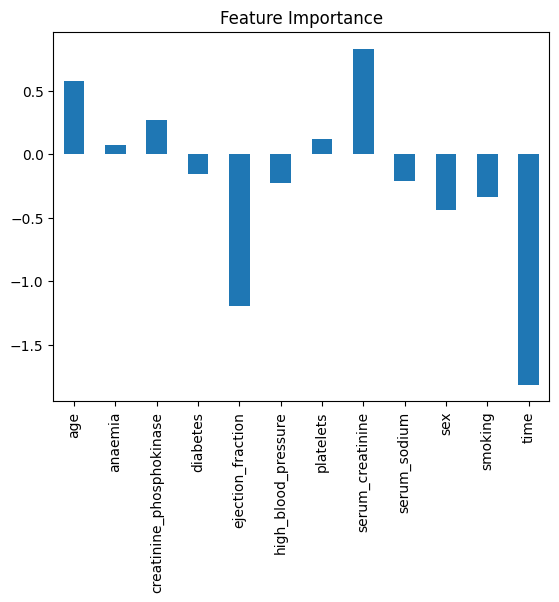

In [150]:
# Visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance", legend=False);